# Building a classifier for detecting tuberculosis in chest X-rays
By Jonathan Feenstra (s1024219) and Justin Huberts (s1030368)

## Some example images:

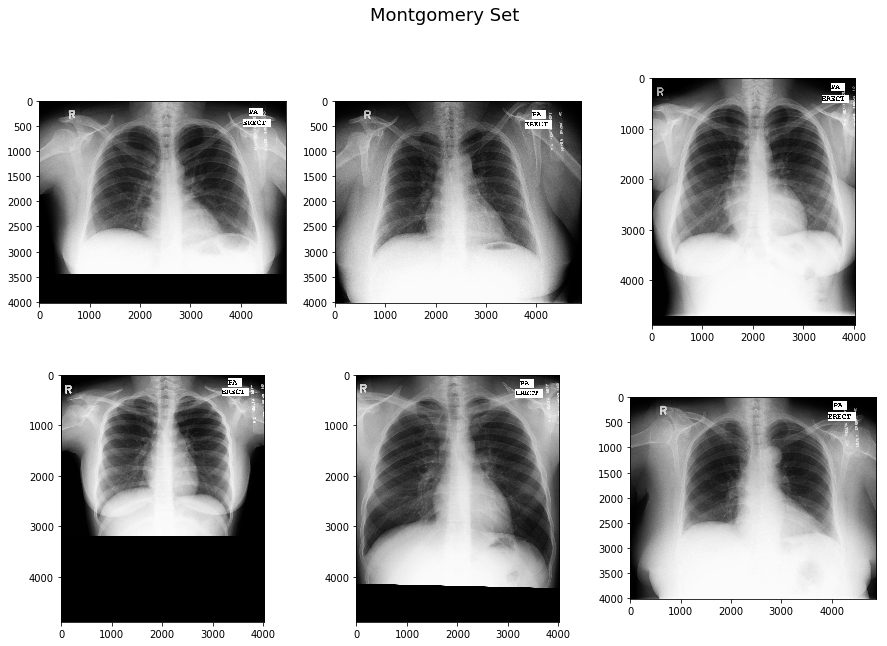

<Figure size 1080x720 with 0 Axes>

In [41]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import ndimage
import numpy as np
import glob
%matplotlib inline

mont_set = glob.glob('Data/MontgomerySet/CXR_png/*.png')
chin_set = glob.glob('Data/ChinaSet_AllFiles/CXR_png/*.png')

mont_fig = plt.figure(figsize=(15,10))
mont_fig.suptitle('Montgomery Set', size=18)
for i, filename in enumerate(mont_set[:6]):
    img = mpimg.imread(filename)
    plt.subplot(2, 3, i + 1)
    plt.imshow(img, cmap='gray')

plt.show()

chin_fig = plt.figure(figsize=(15,10))
chin_fig.suptitle('China Set', size=18)
for i, filename in enumerate(chin_set[:6]):
    img = mpimg.imread(filename)
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    
plt.show()

## Pre-processing
### Step 1: Trim the Montgomery set images to remove empty space

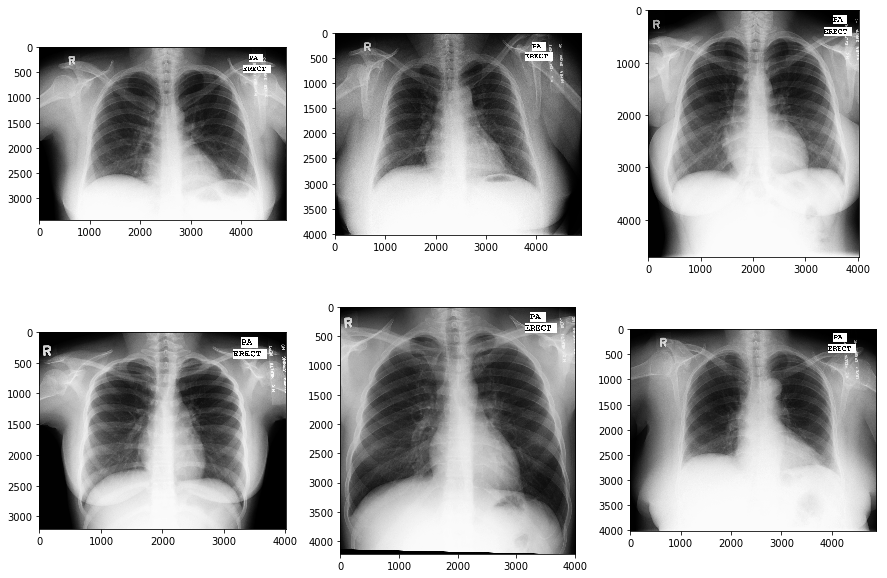

In [42]:
from PIL import Image, ImageChops
import numpy as np

def trim(im):
    bg = Image.new(im.mode, im.size, im.getpixel((0,0)))
    diff = ImageChops.difference(im, bg)
    diff = ImageChops.add(diff, diff, 2.0, -100)
    bbox = diff.getbbox()
    if bbox:
        return im.crop(bbox)

plt.figure(figsize=(15,10))
for i, filename in enumerate(mont_set[:6]):
    img = Image.open(filename)
    plt.subplot(2, 3, i + 1)
    plt.imshow(np.array(trim(img)), cmap='gray') # Ik krijg errors als ik geen np.array gebruik
    #plt.yticks(np.arange(0, 4001, 500))
    
plt.show()

### Step 2: Remove other obstacles

In [43]:
from PIL import Image
import numpy as np
import cv2
from matplotlib import pyplot as plt

img = Image.open('Data\\MontgomerySet\\CXR_png\\MCUCXR_0001_0.png')
# bw = img.point(lambda x: 0 if x<128 else 255, '1')
# imshow(bw)
# plt.show()

# Let numpy do the heavy lifting for converting pixels to pure black or white
#bw = np.asarray(img)
bw = np.array(img)

bw.setflags(write=1)

# Pixel range is 0...255, 256/2 = 128
bw[bw < 128] = 0    # Black
bw[bw >= 128] = 255 # White
imfile = Image.fromarray(bw)

#imfile.save('fil.png')

imshow(imfile)
plt.show()

import cv2
from matplotlib import pyplot as plt

img = cv2.imread('fil.png',0)
edges = cv2.Canny(img,50,200)

plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

plt.show()

from skimage import feature, io
 
im = io.imread('fil.png')
edges = feature.canny(im)
io.imshow(edges)
io.show()


 
im = cv2.imread('fil.png')
edges = cv2.Canny(im,25,255,L2gradient=False)
plt.imshow(edges,cmap='gray')
plt.show()

NameError: name 'imshow' is not defined

### Step 3: Reconstruct the images using an autoencoder

In [47]:
from keras.layers import Input, Dense
from keras.models import Model

#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#scaled_data = scaler.fit_transform(data)

import numpy as np
import random

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(4892, 4020))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(4892, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model


decoder = Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

mont_set.sort()
random.seed(42)
random.shuffle(mont_set) # shuffles the ordering of the data

split_1 = int(0.8 * len(mont_set))
split_2 = int(0.9 * len(mont_set))
x_train = np.array(mont_set[:split_1])
#dev_filenames = mont_set[split_1:split_2]
x_test = np.array(mont_set[split_2:])

x_train = x_train.reshape((len(x_train), int(np.prod(x_train.shape[1:]))))
x_test = x_test.reshape((len(x_test), int(np.prod(x_test.shape[1:]))))

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

# use Matplotlib 
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 4))

for img in range(10):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

ValueError: Error when checking input: expected input_64 to have 3 dimensions, but got array with shape (110, 1)

### Step 4: Suppress the bone structure in both datasets using PCA

## ELM classifier
Train and test a binary ELM classifier using the extension for scikit-learn. Evaluate it for both of the datasets with an ROC-curve and a confusion matrix.